### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import math
import pmdarima as pm

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore','statsmodels.tsa.ar_model.AR', FutureWarning)

from pandas.plotting import lag_plot,autocorrelation_plot
#from pylab import rcParams

from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg,ARResults
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


In [2]:
df = pd.read_csv("Bike Rental UCI dataset.csv",parse_dates=['dteday'])

In [3]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [5]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [6]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'], dtype='object')

### Drop unwanted features / Simplifying the Dataset

In [7]:
df.drop(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday','weathersit','temp', 'atemp', 'hum', 'windspeed',
        'casual', 'registered'],axis=1,inplace=True)

In [8]:
df.head()

,dteday,cnt
0,2011-01-01,16
1,2011-01-01,40
2,2011-01-01,32
3,2011-01-01,13
4,2011-01-01,1


In [9]:
#df.to_csv("bikelite.csv",index=False)

In [10]:
#df = pd.read_csv("bikelite.csv", parse_dates=['dteday'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dteday  17379 non-null  datetime64[ns]
 1   cnt     17379 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 271.7 KB


In [12]:
df2 = df.groupby('dteday').sum()
df2

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-12-27,2114
2012-12-28,3095
2012-12-29,1341


In [13]:
df2.reset_index(inplace=True)

In [14]:
df2

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [15]:
df2.shape

(731, 2)

In [16]:
#df2.to_csv("bikeseries.csv",index=False)

In [17]:
#df2.loc[0]

In [18]:
#df2.describe()

## Feature Engineering

In [19]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'])

In [20]:
df.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


### Date time features

In [21]:
df['year'] = df['dteday'].dt.year

In [22]:
df['month'] = df['dteday'].dt.month

In [23]:
df['day'] = df['dteday'].dt.day

In [24]:
df.head()

,dteday,cnt,year,month,day
0,2011-01-01,985,2011,1,1
1,2011-01-02,801,2011,1,2
2,2011-01-03,1349,2011,1,3
3,2011-01-04,1562,2011,1,4
4,2011-01-05,1600,2011,1,5


### Lag Features

In [25]:
df['lag1'] = df['dteday'].shift(1)

In [26]:
df['lag2'] = df['dteday'].shift(365)

In [27]:
df

,dteday,cnt,year,month,day,lag1,lag2
0,2011-01-01,985,2011,1,1,NaT,NaT
1,2011-01-02,801,2011,1,2,2011-01-01,NaT
2,2011-01-03,1349,2011,1,3,2011-01-02,NaT
3,2011-01-04,1562,2011,1,4,2011-01-03,NaT
4,2011-01-05,1600,2011,1,5,2011-01-04,NaT
...,...,...,...,...,...,...,...
726,2012-12-27,2114,2012,12,27,2012-12-26,2011-12-28
727,2012-12-28,3095,2012,12,28,2012-12-27,2011-12-29
728,2012-12-29,1341,2012,12,29,2012-12-28,2011-12-30
729,2012-12-30,1796,2012,12,30,2012-12-29,2011-12-31


### Window features

In [28]:
df["roll_mean"] = df["cnt"].rolling(window=2).mean()

In [29]:
df

,dteday,cnt,year,month,day,lag1,lag2,roll_mean
0,2011-01-01,985,2011,1,1,NaT,NaT,NaN
1,2011-01-02,801,2011,1,2,2011-01-01,NaT,893.0
2,2011-01-03,1349,2011,1,3,2011-01-02,NaT,1075.0
3,2011-01-04,1562,2011,1,4,2011-01-03,NaT,1455.5
4,2011-01-05,1600,2011,1,5,2011-01-04,NaT,1581.0
...,...,...,...,...,...,...,...,...
726,2012-12-27,2114,2012,12,27,2012-12-26,2011-12-28,1277.5
727,2012-12-28,3095,2012,12,28,2012-12-27,2011-12-29,2604.5
728,2012-12-29,1341,2012,12,29,2012-12-28,2011-12-30,2218.0
729,2012-12-30,1796,2012,12,30,2012-12-29,2011-12-31,1568.5


In [30]:
df["roll_max"] = df["cnt"].rolling(window=3).max()  #Previous 3 periods

In [31]:
df

,dteday,cnt,year,month,day,lag1,lag2,roll_mean,roll_max
0,2011-01-01,985,2011,1,1,NaT,NaT,NaN,NaN
1,2011-01-02,801,2011,1,2,2011-01-01,NaT,893.0,NaN
2,2011-01-03,1349,2011,1,3,2011-01-02,NaT,1075.0,1349.0
3,2011-01-04,1562,2011,1,4,2011-01-03,NaT,1455.5,1562.0
4,2011-01-05,1600,2011,1,5,2011-01-04,NaT,1581.0,1600.0
...,...,...,...,...,...,...,...,...,...
726,2012-12-27,2114,2012,12,27,2012-12-26,2011-12-28,1277.5,2114.0
727,2012-12-28,3095,2012,12,28,2012-12-27,2011-12-29,2604.5,3095.0
728,2012-12-29,1341,2012,12,29,2012-12-28,2011-12-30,2218.0,3095.0
729,2012-12-30,1796,2012,12,30,2012-12-29,2011-12-31,1568.5,3095.0


### Expanding features

In [32]:
df['expand_max'] = df['cnt'].expanding().max()

In [33]:
df

,dteday,cnt,year,month,day,lag1,lag2,roll_mean,roll_max,expand_max
0,2011-01-01,985,2011,1,1,NaT,NaT,NaN,NaN,985.0
1,2011-01-02,801,2011,1,2,2011-01-01,NaT,893.0,NaN,985.0
2,2011-01-03,1349,2011,1,3,2011-01-02,NaT,1075.0,1349.0,1349.0
3,2011-01-04,1562,2011,1,4,2011-01-03,NaT,1455.5,1562.0,1562.0
4,2011-01-05,1600,2011,1,5,2011-01-04,NaT,1581.0,1600.0,1600.0
...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,2114,2012,12,27,2012-12-26,2011-12-28,1277.5,2114.0,8714.0
727,2012-12-28,3095,2012,12,28,2012-12-27,2011-12-29,2604.5,3095.0,8714.0
728,2012-12-29,1341,2012,12,29,2012-12-28,2011-12-30,2218.0,3095.0,8714.0
729,2012-12-30,1796,2012,12,30,2012-12-29,2011-12-31,1568.5,3095.0,8714.0


In [ ]:
#df.to_csv("bikefeature.csv",index=False)

## Time-Series Visualization

In [34]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'],index_col='dteday')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB


In [36]:
df.index.freq = "D"

In [37]:
df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


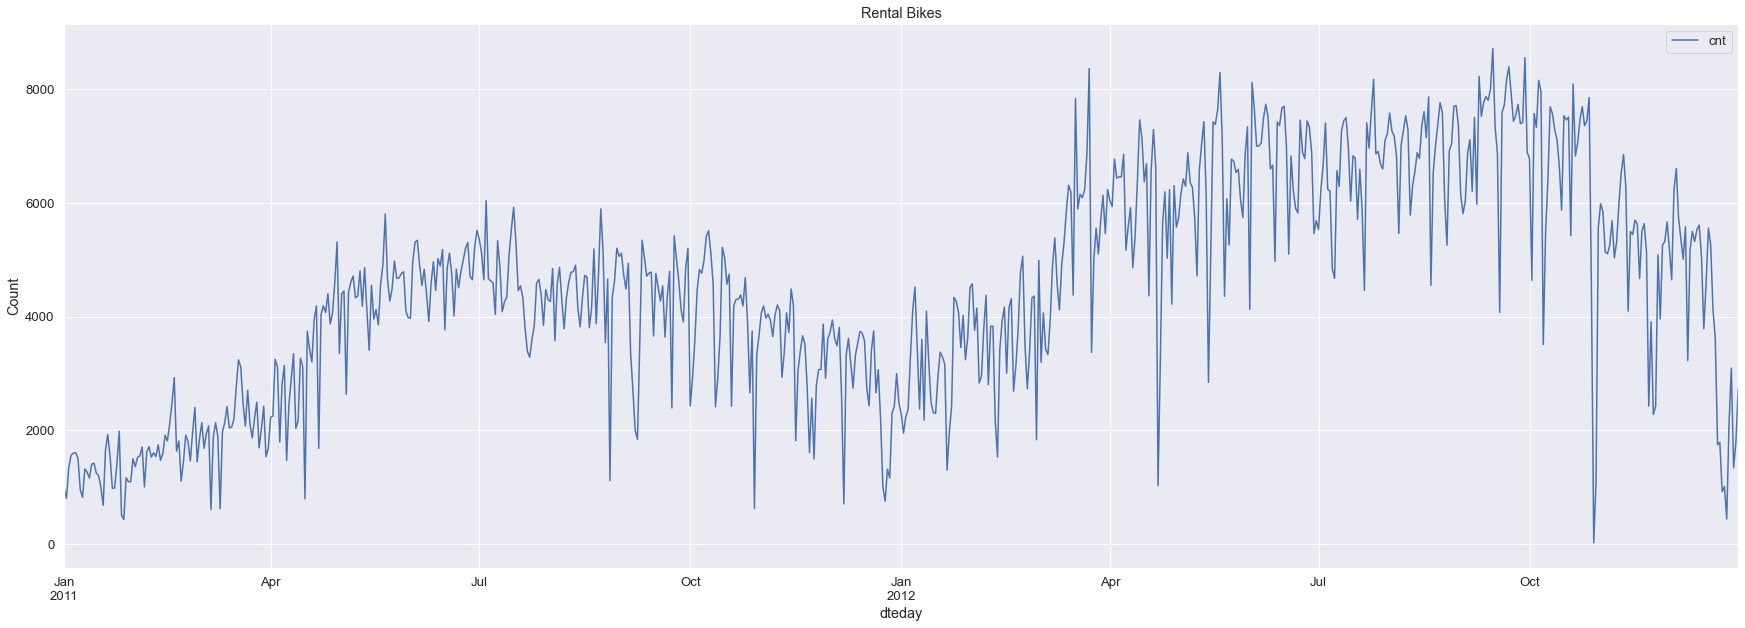

In [38]:
df.plot(figsize=(30,10), title="Rental Bikes")
plt.ylabel("Count")
plt.show()

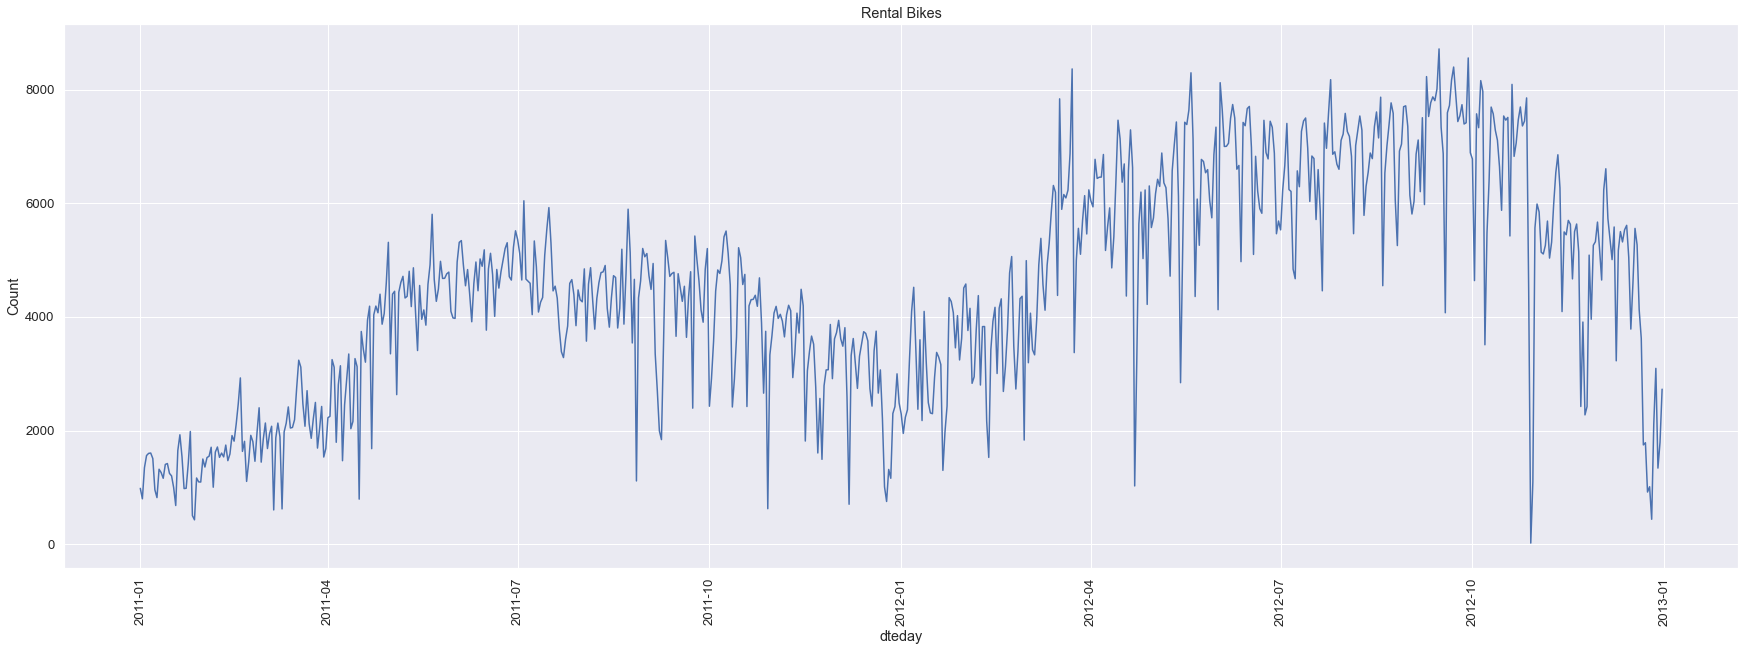

In [39]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=df.index,y=df.cnt,data=df, estimator=None)
plt.xticks(rotation=90)
plt.title("Rental Bikes")
plt.ylabel("Count")
plt.show()

### Zooming in date range

In [40]:
zoomjan = df[(df.index >= '2011-01-01') & (df.index <= '2011-01-31')]

In [41]:
zoomjan

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
2011-01-06,1606
2011-01-07,1510
2011-01-08,959
2011-01-09,822


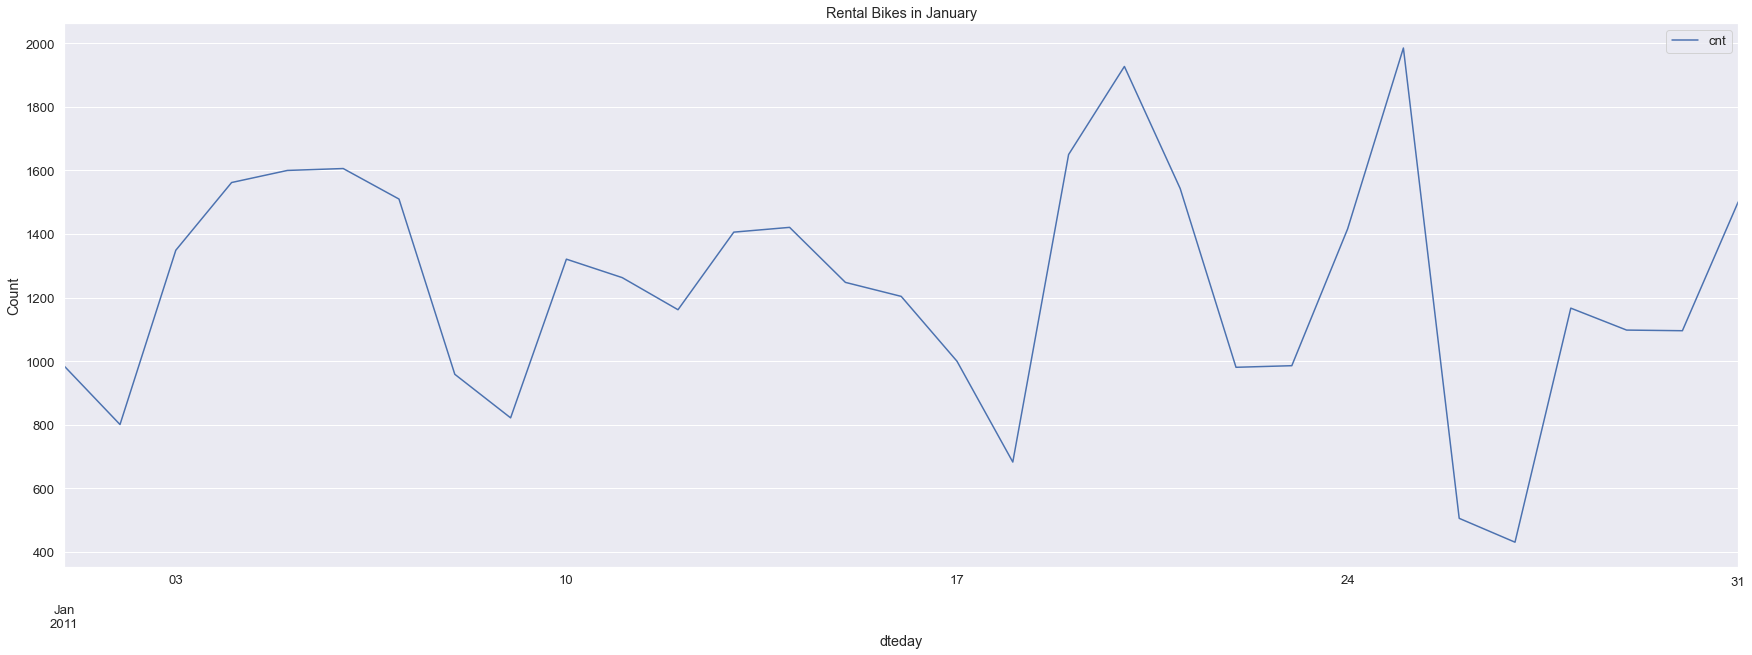

In [42]:
zoomjan.plot(figsize=(30,10), title="Rental Bikes in January")
plt.ylabel("Count")
plt.show()

### Trendline

In [43]:
df.reset_index(inplace=True)

In [44]:
df.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


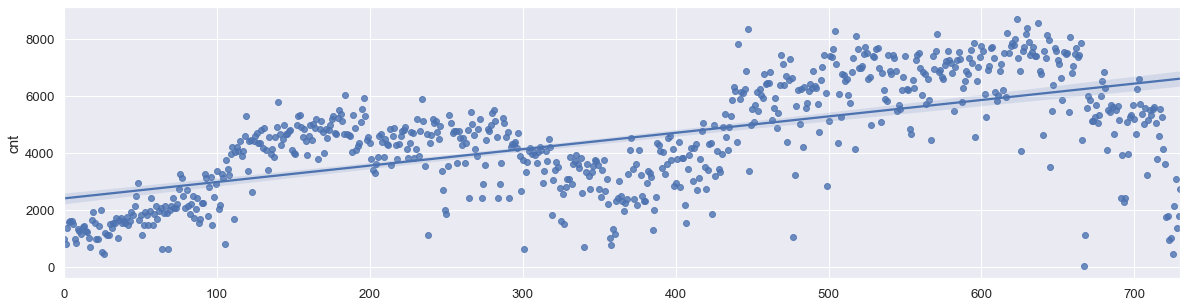

In [45]:
plt.figure(figsize=(20,5))
sns.regplot(x=df.index.values, y=df['cnt'], order=1)
plt.show()

### Removing seasonality

In [46]:
df['month'] = df['dteday'].dt.month

In [47]:
df

,dteday,cnt,month
0,2011-01-01,985,1
1,2011-01-02,801,1
2,2011-01-03,1349,1
3,2011-01-04,1562,1
4,2011-01-05,1600,1
...,...,...,...
726,2012-12-27,2114,12
727,2012-12-28,3095,12
728,2012-12-29,1341,12
729,2012-12-30,1796,12


In [48]:
df.groupby('month')['cnt'].mean()

month
1     2176.338710
2     2655.298246
3     3692.258065
4     4484.900000
5     5349.774194
6     5772.366667
7     5563.677419
8     5664.419355
9     5766.516667
10    5199.225806
11    4247.183333
12    3403.806452
Name: cnt, dtype: float64

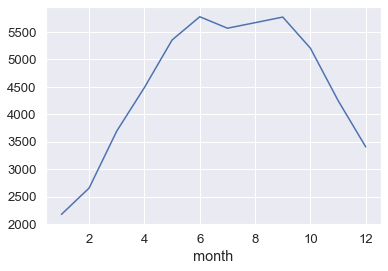

In [49]:
df.groupby('month')['cnt'].mean().plot()
plt.show()

### Creating Lag plots

In [50]:
df['lag1'] = df['cnt'].shift(1)

In [51]:
df.head()

,dteday,cnt,month,lag1
0,2011-01-01,985,1,NaN
1,2011-01-02,801,1,985.0
2,2011-01-03,1349,1,801.0
3,2011-01-04,1562,1,1349.0
4,2011-01-05,1600,1,1562.0


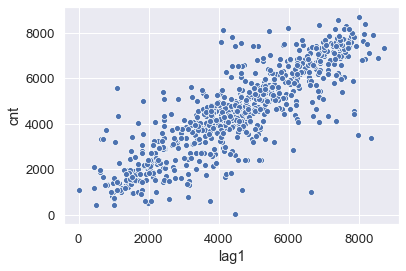

In [52]:
sns.scatterplot(x=df.lag1,y=df.cnt,data=df)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


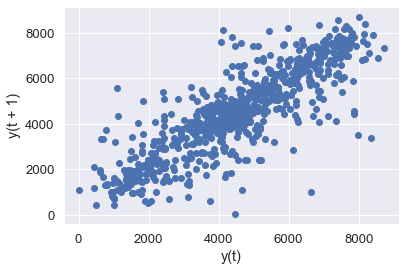

In [53]:
lag_plot(df['cnt'])
plt.show()

### Autocorrelation Plots

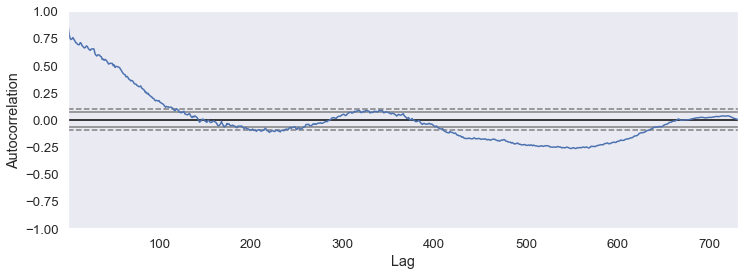

In [54]:
plt.figure(figsize=(12,4))
autocorrelation_plot(df['cnt'])
plt.show()

## Downsampling and Upsampling

In [55]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'])

In [56]:
df.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


### Downsampling

In [57]:
quarterly_df = df.resample(rule='Q', on='dteday').sum()

In [58]:
quarterly_df

,cnt
dteday,
2011-03-31,150449
2011-06-30,374203
2011-09-30,405450
2011-12-31,313001
2012-03-31,364756
2012-06-30,572919
2012-09-30,636683
2012-12-31,475218


In [59]:
weekly_df = df.resample(rule='W', on='dteday').sum()

In [60]:
weekly_df

,cnt
dteday,
2011-01-02,1786
2011-01-09,9408
2011-01-16,9025
2011-01-23,8770
2011-01-30,7699
...,...
2012-12-09,37762
2012-12-16,35966
2012-12-23,26696


## Decomposing Time Series

### Additive or Multiplication model

In [61]:
decomp_df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col='dteday')

In [62]:
decomp_df.index.freq = "D"

In [63]:
decomp_df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [64]:
result = seasonal_decompose(x=decomp_df['cnt'], model='additive')

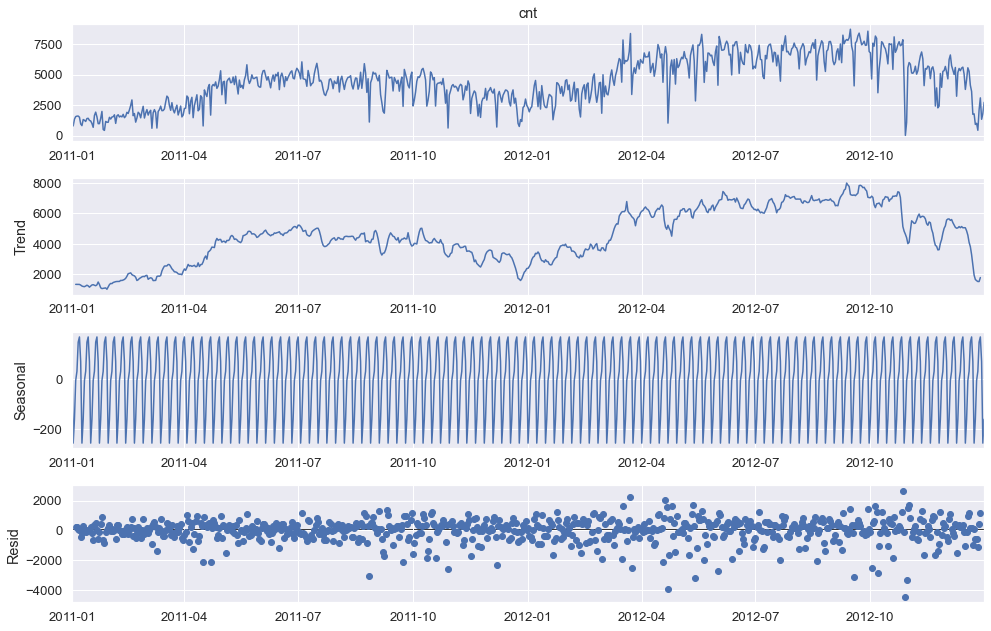

In [65]:
#plt.title("Additive Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result.plot()
plt.show()

In [66]:
result2 = seasonal_decompose(x=decomp_df['cnt'], model='multiplicative')

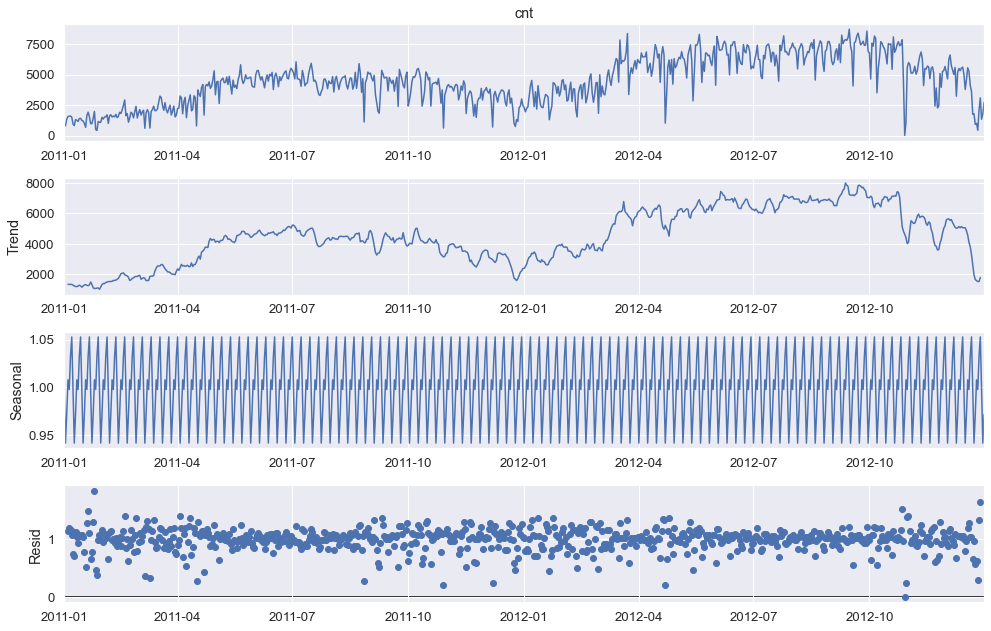

In [67]:
#plt.title("Multiplicative Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result2.plot()
plt.show()

## Convert Non-Stationary to Stationary

### Differencing Method

In [68]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col="dteday")

In [69]:
df.index.freq = "D"

In [70]:
df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [71]:
df["lag1"] = df['cnt'].shift(1)

In [72]:
df["diff1"] = df['cnt'].diff(periods=1)

In [73]:
df.head()

,cnt,lag1,diff1
dteday,,,
2011-01-01,985,NaN,NaN
2011-01-02,801,985.0,-184.0
2011-01-03,1349,801.0,548.0
2011-01-04,1562,1349.0,213.0
2011-01-05,1600,1562.0,38.0


In [74]:
result_a = seasonal_decompose(x=df["cnt"],model='additive')

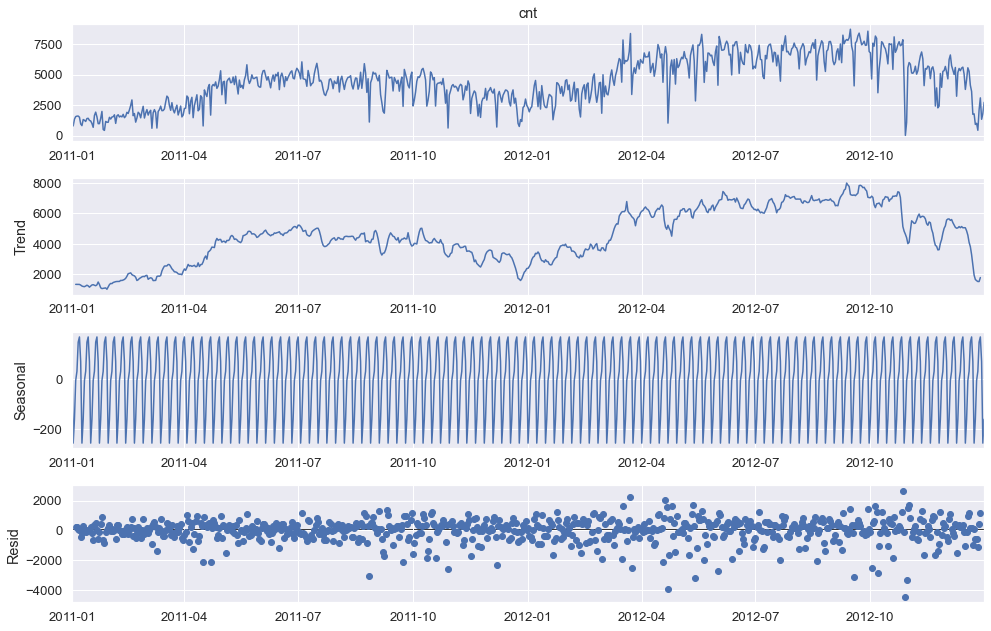

In [75]:
plt.rcParams['figure.figsize'] = (14,9)
result_a.plot()
plt.show()

In [76]:
#Select diff1
result_b = seasonal_decompose(x=df.iloc[1:,2], model='additive')

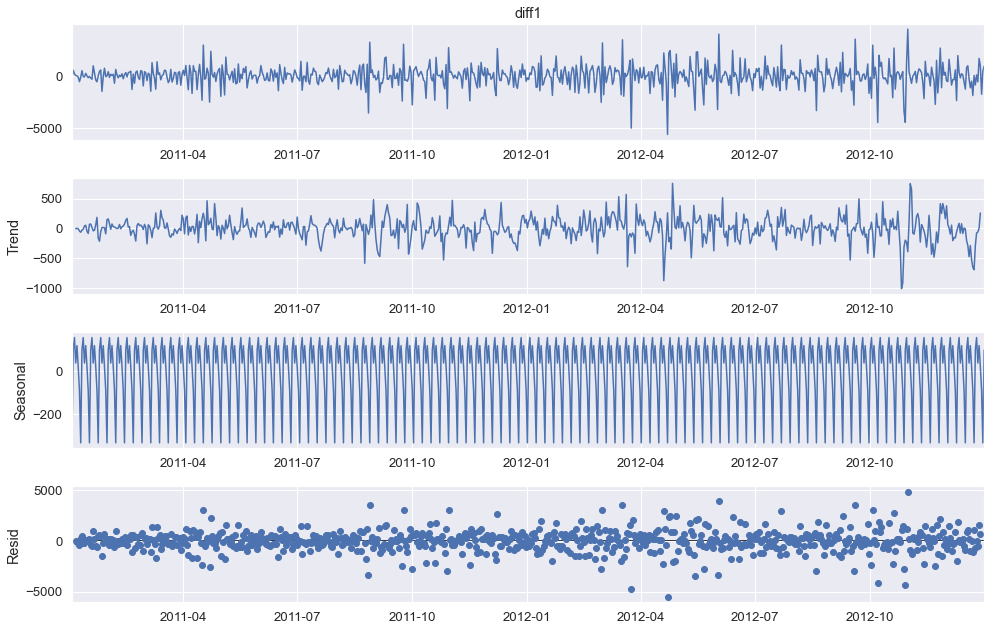

In [77]:
plt.rcParams['figure.figsize'] = (14,9)
result_b.plot()
plt.show()

In [78]:
#Remove seasonal components
df["diff2"] = df['diff1'].diff(periods=1)

In [79]:
df.head()

,cnt,lag1,diff1,diff2
dteday,,,,
2011-01-01,985,NaN,NaN,NaN
2011-01-02,801,985.0,-184.0,NaN
2011-01-03,1349,801.0,548.0,732.0
2011-01-04,1562,1349.0,213.0,-335.0
2011-01-05,1600,1562.0,38.0,-175.0


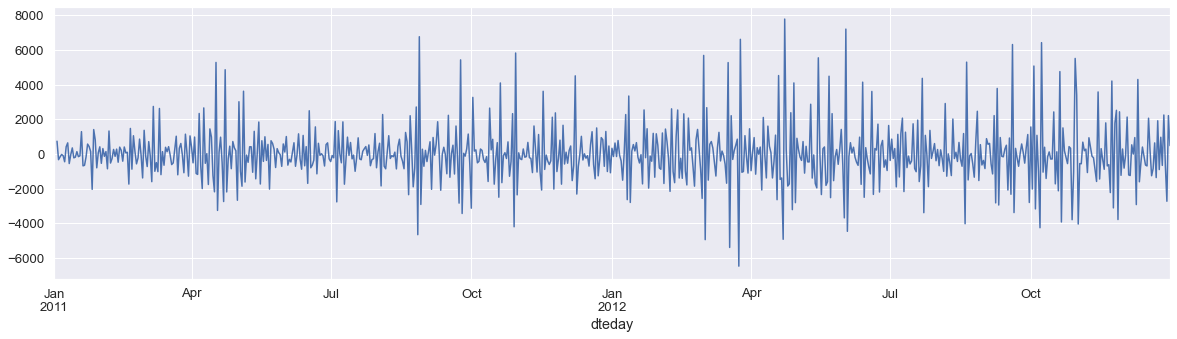

In [80]:
df["diff2"].plot(figsize=(20,5))
plt.show()

In [81]:
#Check diff2
result_c = seasonal_decompose(df.iloc[2:,3])

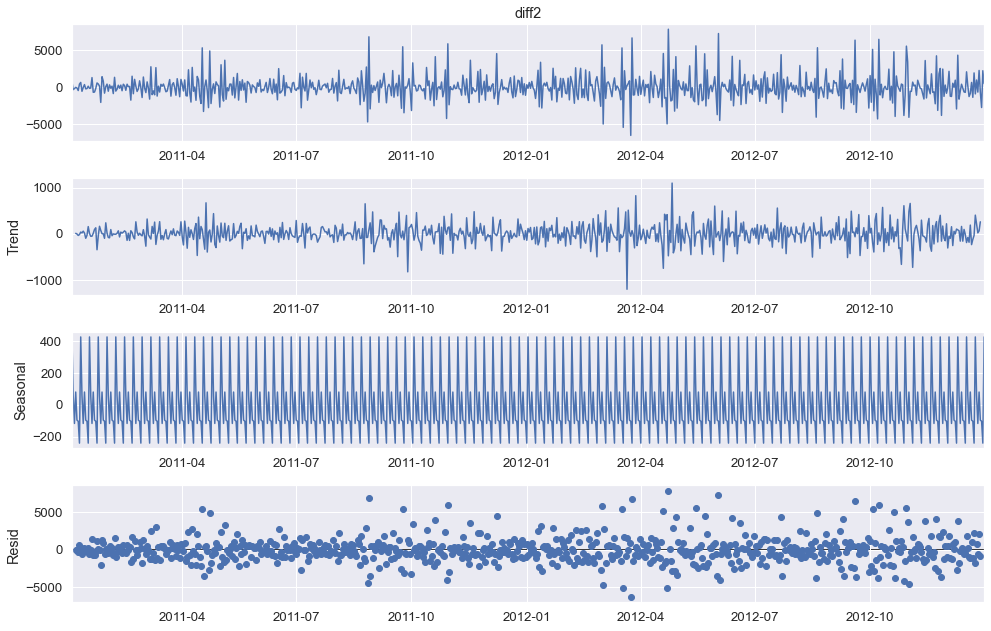

In [82]:
plt.rcParams['figure.figsize'] = (14,9)
result_c.plot()
plt.show()

In [83]:
#Seasonal First Difference
df["Seasonal First Difference"] = df["cnt"] - df["cnt"].shift(12)

In [84]:
df.head(14)

,cnt,lag1,diff1,diff2,Seasonal First Difference
dteday,,,,,
2011-01-01,985,NaN,NaN,NaN,NaN
2011-01-02,801,985.0,-184.0,NaN,NaN
2011-01-03,1349,801.0,548.0,732.0,NaN
2011-01-04,1562,1349.0,213.0,-335.0,NaN
2011-01-05,1600,1562.0,38.0,-175.0,NaN
2011-01-06,1606,1600.0,6.0,-32.0,NaN
2011-01-07,1510,1606.0,-96.0,-102.0,NaN
2011-01-08,959,1510.0,-551.0,-455.0,NaN
2011-01-09,822,959.0,-137.0,414.0,NaN


In [85]:
#Save as csv
#df.to_csv('cleaned.csv',index=True)

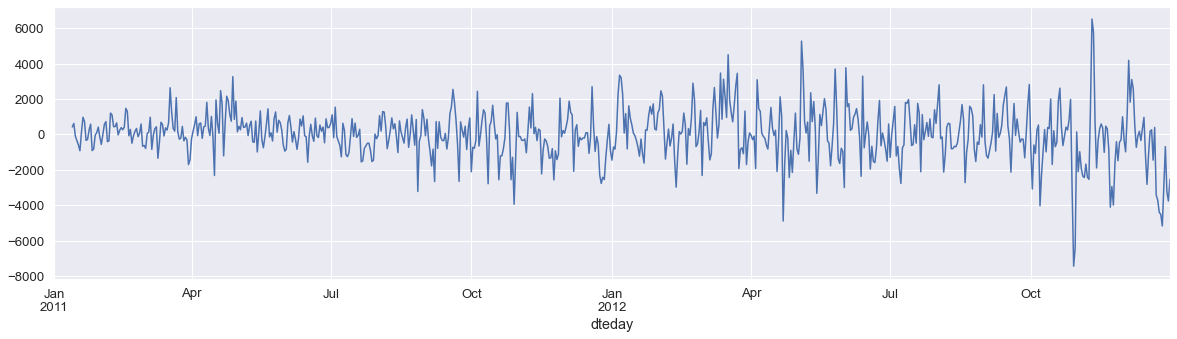

In [86]:
df["Seasonal First Difference"].plot(figsize=(20,5))
plt.show()

In [87]:
result_d = seasonal_decompose(df.iloc[12:,4])

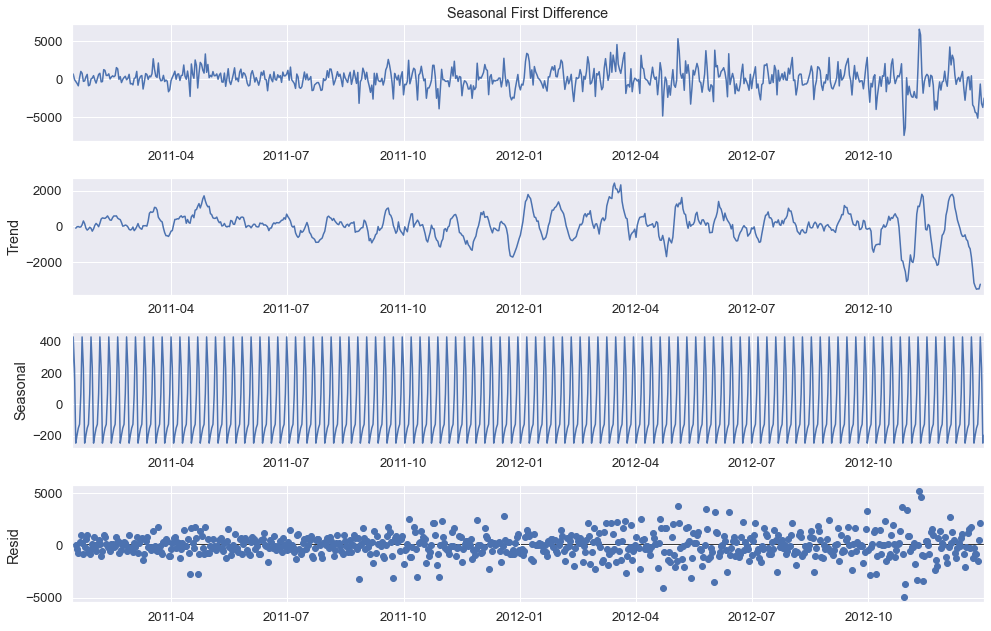

In [88]:
plt.rcParams['figure.figsize'] = (14,9)
result_d.plot()
plt.show()

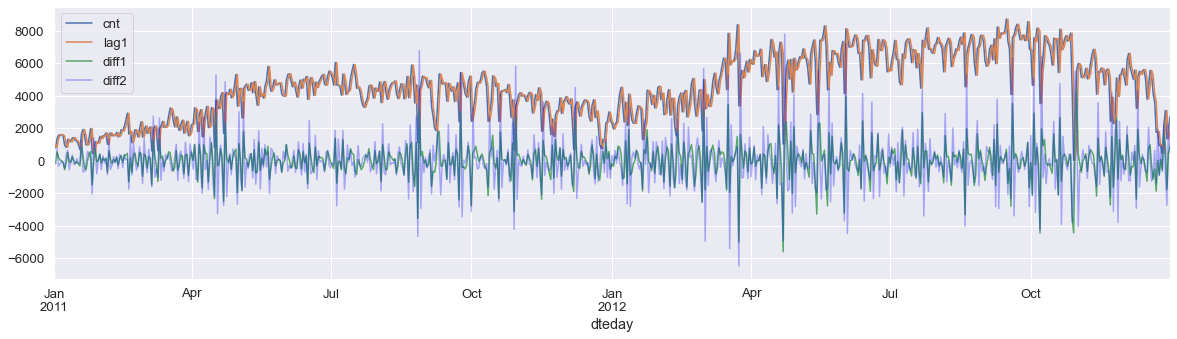

In [89]:
df.cnt.plot(legend=True,figsize=(20,5))
df.lag1.plot(legend=True)
df.diff1.plot(legend=True)
df.diff2.plot(legend=True, color='blue', alpha=0.3)
plt.show()

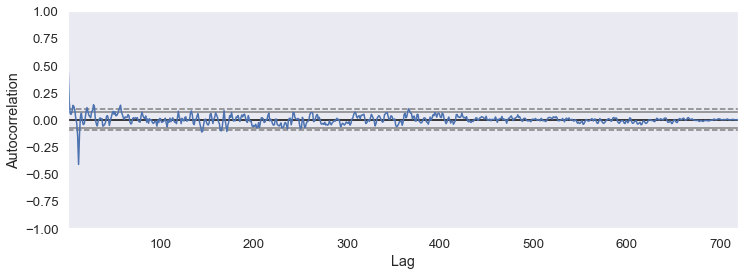

In [90]:
#Autocorrelation Plot
plt.rcParams['figure.figsize'] = (12,4)
autocorrelation_plot(df["Seasonal First Difference"].dropna())
plt.show()

## Stationarity Tests

In [97]:
df = pd.read_csv("cleaned.csv", parse_dates=['dteday'], index_col="dteday")

In [98]:
df.index.freq = "D"

In [99]:
df.head()

,cnt,lag1,diff1,diff2,seasonal1
dteday,,,,,
2011-01-01,985,NaN,NaN,NaN,NaN
2011-01-02,801,985.0,-184.0,NaN,NaN
2011-01-03,1349,801.0,548.0,732.0,NaN
2011-01-04,1562,1349.0,213.0,-335.0,NaN
2011-01-05,1600,1562.0,38.0,-175.0,NaN


In [100]:
adfuller(df.cnt)

(-1.8774481444374302,
 0.3427434403392191,
 13,
 717,
 {'1%': -3.439503230053971,
  '5%': -2.8655794463678346,
  '10%': -2.5689210707289982},
 11740.390931163352)

In [101]:
dftest = adfuller(df['cnt'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
print(dfout)

ADF Test Statistic      -1.877448
p-value                  0.342743
# Lags Used             13.000000
# Observations         717.000000
critical value(1%)      -3.439503
critical value(5%)      -2.865579
critical value(10%)     -2.568921
dtype: float64


Result: Fail to reject null hypothesis and data is non-stationary

In [102]:
print("ADF Test for Diff1")

dftest = adfuller(df.iloc[1:,2])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
print(dfout)

ADF Test for Diff1
ADF Test Statistic    -1.177881e+01
p-value                1.046780e-21
# Lags Used            1.200000e+01
# Observations         7.170000e+02
critical value(1%)    -3.439503e+00
critical value(5%)    -2.865579e+00
critical value(10%)   -2.568921e+00
dtype: float64


In [103]:
print("ADF Test for Diff2")

dftest = adfuller(df.iloc[2:,3])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
dfout

ADF Test for Diff2


ADF Test Statistic    -1.227908e+01
p-value                8.302729e-23
# Lags Used            2.000000e+01
# Observations         7.080000e+02
critical value(1%)    -3.439620e+00
critical value(5%)    -2.865631e+00
critical value(10%)   -2.568948e+00
dtype: float64

In [105]:
adfuller(df["seasonal1"].dropna())

(-4.030604564274394,
 0.001258468387063869,
 19,
 699,
 {'1%': -3.439739809554328,
  '5%': -2.86568368980381,
  '10%': -2.5689766074363334},
 11815.322388931094)

In [106]:
print("ADF Test for Seasonal First Difference")

dftest = adfuller(df["seasonal1"].dropna())
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
dfout

ADF Test for Seasonal First Difference


ADF Test Statistic      -4.030605
p-value                  0.001258
# Lags Used             19.000000
# Observations         699.000000
critical value(1%)      -3.439740
critical value(5%)      -2.865684
critical value(10%)     -2.568977
dtype: float64

## ACF

In [107]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'])

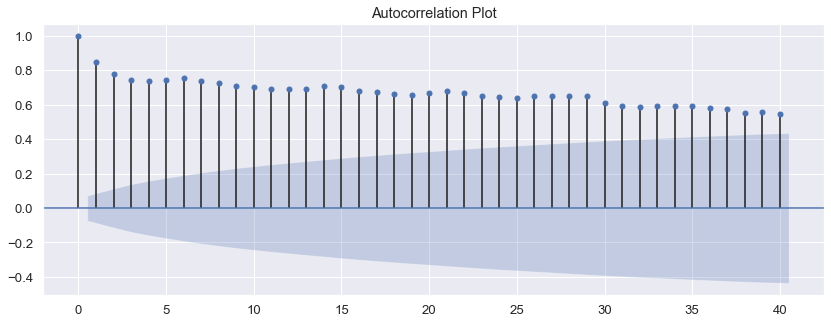

In [108]:
plt.rcParams['figure.figsize'] = (14,5)
sgt.plot_acf(df.cnt, lags=40)
plt.title("Autocorrelation Plot")
plt.show()

Looking at the ACF plot, we only see a significant peak at lag 1, suggesting a non-seasonal MA(1) process.

## PACF

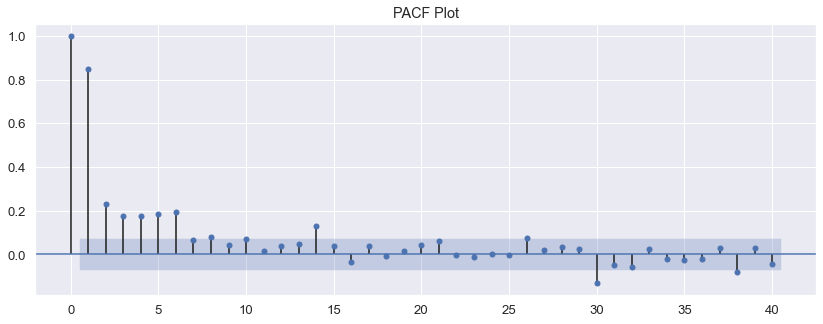

In [109]:
plt.rcParams['figure.figsize'] = (14,5)
sgt.plot_pacf(df.cnt, lags=40, method='ols')
plt.title("PACF Plot")
plt.show()

We can see from the PACF that we have a significant peak at lag 1, which suggest an AR(1) process. Also, we have another peak at lag 6, suggesting a seasonal autoregressive process of order 1 (P = 1)

## Train-Test Split

In [110]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [111]:
df.index.freq = "D"

In [112]:
df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [113]:
len(df)

731

In [114]:
size = int(len(df)*0.8)

In [115]:
size

584

In [116]:
train = df.iloc[:size]

In [117]:
test = df.iloc[size:]

In [118]:
train

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-08-02,7261
2012-08-03,7175
2012-08-04,6824


In [119]:
test

,cnt
dteday,
2012-08-07,7273
2012-08-08,7534
2012-08-09,7286
2012-08-10,5786
2012-08-11,6299
...,...
2012-12-27,2114
2012-12-28,3095
2012-12-29,1341


In [120]:
train.shape, test.shape

((584, 1), (147, 1))

## Time-series modeling

### Holt Winters Method

In [ ]:
fitted_model = ExponentialSmoothing(endog=train["cnt"], trend="additive",seasonal="additive", 
                                    seasonal_periods=12).fit()

In [ ]:
hwpred = fitted_model.forecast(30)

In [ ]:
hwpred

In [ ]:
test_data = test[:30]

In [ ]:
test_data

In [ ]:
train['cnt'].plot(legend=True,label="TRAIN",figsize=(16,5))
test['cnt'].plot(legend=True,label="TEST")
hwpred.plot(legend=True,label="PREDICTION")
plt.show()

In [ ]:
#Zoom into selected time frame
train['cnt'].plot(legend=True,label="TRAIN",figsize=(16,5))
test['cnt'].plot(legend=True,label="TEST")
hwpred.plot(legend=True,label="PREDICTION",xlim=['2012-08-07','2012-09-05'])
plt.show()

In [ ]:
test.describe()

In [ ]:
mse = mean_squared_error(test_data,hwpred)
mse

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data,hwpred))
rmse

In [ ]:
fitted_model2 = ExponentialSmoothing(endog=train["cnt"], trend="multiplicative",seasonal="multiplicative", 
                                    seasonal_periods=12).fit()

In [ ]:
hwpred2 = fitted_model2.forecast(30)

In [ ]:
hwpred2

In [ ]:
test_data = test[:30]

In [ ]:
test_data

In [ ]:
train['cnt'].plot(legend=True,label="TRAIN",figsize=(16,5))
test['cnt'].plot(legend=True,label="TEST")
hwpred2.plot(legend=True,label="PREDICTION2")
plt.show()

In [ ]:
mse = mean_squared_error(test_data,hwpred2)
mse

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data,hwpred2))
rmse

### Naive(Persistence Model)

In [ ]:
df = pd.read_csv("cleaned.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.index.freq = "D"

In [ ]:
df.head()

In [ ]:
df['t'] = df["cnt"].shift(1)

In [ ]:
df.head()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train

In [ ]:
train = train[1:]

In [ ]:
train

In [ ]:
test

In [ ]:
train.shape, test.shape

In [ ]:
train_X, train_y = train['t'], train["cnt"]
test_X, test_y = test['t'], test["cnt"]

In [ ]:
predictions = test_X.copy()

In [ ]:
print(predictions)
print(test_y)

### Naive Model Evaluation

In [ ]:
mse = mean_squared_error(test_y,predictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_y)
plt.plot(predictions)
plt.legend(["test_y","predictions"])
plt.title("Comparison of Real Test versus Predictions")
plt.show()

### Autoregression Model

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df = pd.read_csv("cleaned.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.head()

In [ ]:
df.index.freq ='D'

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train.shape, test.shape

In [ ]:
armodel = AutoReg(endog=train['cnt'],lags=1,trend='c',seasonal=False)

In [ ]:
armodel_fit = armodel.fit()

In [ ]:
armodel_fit.params

In [ ]:
armodel_fit.summary()

In [ ]:
arpredictions = armodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions

In [ ]:
print(test['cnt'])

In [ ]:
mse = mean_squared_error(test, arpredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions)
plt.legend(["test","AR Predictions"])
plt.title("Test and AR Predictions Graph")
plt.show()

In [ ]:
test["cnt"].plot(legend=True, figsize=(20,5))
arpredictions.plot(legend=True)
plt.title("Test and AR Predictions Graph")
plt.show()

### Method 2

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.head()

In [ ]:
df.index.freq ='D'

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train.shape, test.shape

In [ ]:
armodel = ARMA(train["cnt"],order=(1,0))

In [ ]:
armodel_fit = armodel.fit()

In [ ]:
armodel_fit.params

In [ ]:
armodel_fit.summary()

In [ ]:
arpredictions = armodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions

In [ ]:
print(test['cnt'])

In [ ]:
mse = mean_squared_error(test, arpredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions)
plt.legend(["test","AR1 Predictions"])
plt.title("Test and AR1 Predictions Graph")
plt.show()

In [ ]:
test["cnt"].plot(legend=True, figsize=(20,5))
arpredictions.plot(legend=True)
plt.title("Test and AR1 Predictions Graph")
plt.show()

### AR2 Model -  Method 1

In [ ]:
armodel2 = AutoReg(endog=train['cnt'],lags=2)

In [ ]:
armodel2_fit = armodel2.fit()

In [ ]:
armodel2_fit.params

In [ ]:
armodel2_fit.summary()

In [ ]:
arpredictions2 = armodel2_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions2

In [ ]:
print(test)

In [ ]:
mse = mean_squared_error(test, arpredictions2)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions2)
plt.legend(["Test","AR2 Predictions"])
plt.title("Test and AR2 Predictions Graph")
plt.show()

In [ ]:
test.plot(legend=True, figsize=(20,5))
arpredictions2.plot(legend=True)
plt.title("Test and AR2 Predictions Graph")
plt.show()

### Method 2

In [ ]:
armodel2 = ARMA(endog=train['cnt'],order=(2,0))

In [ ]:
armodel2_fit = armodel2.fit()

In [ ]:
armodel2_fit.params

In [ ]:
armodel2_fit.summary()

In [ ]:
arpredictions2 = armodel2_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions2

In [ ]:
print(test)

In [ ]:
mse = mean_squared_error(test, arpredictions2)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions2)
plt.legend(["Test","AR2 Predictions"])
plt.title("Test and AR2 Predictions Graph")
plt.show()

In [ ]:
test.plot(legend=True, figsize=(20,5))
arpredictions2.plot(legend=True)
plt.title("Test and AR2 Predictions Graph")
plt.show()

You can increase AR order value to see the summary table for significance level

### Use T-statistics

In [ ]:
ARfit = armodel.fit(use_t=True)

In [ ]:
ARfit.params

In [ ]:
ARfit.summary()

### Moving Average Model

### Method 1

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.index.freq ='D'

In [ ]:
df['t'] = df['cnt'].shift(1)

In [ ]:
df['residual'] = df['cnt'] - df['t']

In [ ]:
df.head()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.residual[1:size]
test = df.residual[size:]

In [ ]:
train.head(), test.head()

In [ ]:
mavgmodel = AutoReg(train, lags=0)

In [ ]:
mavgmodel_fit = mavgmodel.fit()

In [ ]:
mavgmodel_fit.params

In [ ]:
mavgmodel_fit.summary()

In [ ]:
res_predictions = mavgmodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
res_predictions

In [ ]:
df.t[size:]

In [ ]:
predictions = df.t[size:] + res_predictions

In [ ]:
predictions

In [ ]:
test_y = df.cnt[size:]

In [ ]:
test_y

In [ ]:
mse = mean_squared_error(test_y, predictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_y)
plt.plot(predictions)
plt.legend(["Test","MA Predictions"])
plt.title("Test and Moving Average Predictions Graph")
plt.show()

### Method 2

In [ ]:
mavgmodel = ARMA(endog=train.cnt,order=(0,1))

In [ ]:
mavgmodel_fit = mavgmodel.fit()

In [ ]:
mavgmodel_fit.params

In [ ]:
mavgmodel_fit.summary()

In [ ]:
mavg_predictions = mavgmodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
mavg_predictions

In [ ]:
[test]

In [ ]:
mse = mean_squared_error(test, mavg_predictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(mavg_predictions)
plt.legend(["Test","MA Predictions"])
plt.title("Test and Moving Average Predictions Graph")
plt.show()

You can increase MA order value to see the summary table for significance level

### ARMA Model

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.info()

In [ ]:
df.index.freq ='D'

In [ ]:
df['cnt'] = df['cnt'].astype('float64')

In [ ]:
df.info()

In [ ]:
df.index.freq ='D'

In [ ]:
df.head()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.cnt[0:size]
test = df.cnt[size:]

In [ ]:
train.head(), test.head()

In [ ]:
train.shape, test.shape

In [ ]:
armamodel = ARMA(train,order=(2,1))

In [ ]:
armamodel_fit = armamodel.fit(method='css-mle')

In [ ]:
armamodel_fit.params

In [ ]:
armamodel_fit.summary()

In [ ]:
start_date = test.index[0]

In [ ]:
start_date

In [ ]:
end_date = test.index[-1]

In [ ]:
end_date

In [ ]:
armapredictions = armamodel_fit.predict(start=start_date,end=end_date)

In [ ]:
armapredictions

In [ ]:
residuals = test - armapredictions

In [ ]:
residuals

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title("Residuals from AR Model")
plt.ylabel("Error")
plt.axhline(0, color = 'r', alpha=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(armapredictions)
plt.legend(["Test","ARMA Predictions"])
plt.title("Test and ARMA Predictions Graph")
plt.show()

In [ ]:
mse = mean_squared_error(test, armapredictions)
mse

In [ ]:
test.mean()

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
armapredictions.mean()

### ARMA using AutoArima

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.info()

In [ ]:
df['cnt'] = df['cnt'].astype('float64')

In [ ]:
df.info()

In [ ]:
df.index.freq ='D'

In [ ]:
df.head()

In [ ]:
#auto_arima(df['cnt'],seasonal=False, start_p=1, start_q=1).summary()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train, test = df.cnt[0:size], df.cnt[size:]

In [ ]:
train.head(), test.head()

In [ ]:
train.shape, test.shape

### ARIMA Model

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.head()

In [ ]:
df.index.freq ='D'

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.cnt[0:size]
test = df.cnt[size:]

In [ ]:
train.head(), test.head()

In [ ]:
train.shape, test.shape

In [ ]:
arimamodel = ARIMA(train,order=(1,1,1))

In [ ]:
arimamodel_fit = arimamodel.fit()

In [ ]:
arimamodel_fit.summary()

In [ ]:
#residuals = arimamodel_fit.resid

In [ ]:
# residuals.plot(figsize=(20,5), title="Residuals")
# plt.show()

In [ ]:
#residuals.describe()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
start, end

In [ ]:
arimapredictions = arimamodel_fit.predict(start=start, end=end, typ='levels').rename("ARIMA Predictions")

In [ ]:
arimapredictions

In [ ]:
[[test]]

In [ ]:
test = test.astype('float64')

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(arimapredictions)
plt.legend(["Test","ARIMA Predictions"])
plt.title("Test versus ARIMA Predictions Graph")
plt.show()

In [ ]:
test.plot(figsize=(20,5),legend=True)
arimapredictions.plot(legend=True)
plt.title("Test values versus ARIMA predictions")
plt.show()

In [ ]:
mse = mean_squared_error(test,arimapredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
#error = rmse(test,arimapredictions)

In [ ]:
#error

In [ ]:
test.mean()

### SARIMA Model

In [ ]:
df.head()

In [ ]:
df.index.freq = "D"

In [ ]:
sarimamodel = SARIMAX(endog=train, order=(1,1,1), seasonal_order=(1,1,1,12))

In [ ]:
sarimamodel_fit = sarimamodel.fit()

In [ ]:
sarimamodel_fit.summary()

In [ ]:
residuals = sarimamodel_fit.resid

In [ ]:
residuals.plot()
plt.show()

In [ ]:
sarimamodel_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
start, end

In [ ]:
sarimapredictions = sarimamodel_fit.predict(start=start, end=end).rename("SARIMA Predictions")

In [ ]:
sarimapredictions

In [ ]:
[[test]]

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(sarimapredictions)
plt.legend(["Test","SARIMA Predictions"])
plt.title("Test versus SARIMA Predictions Graph")
plt.show()

In [ ]:
test.plot(figsize=(20,5),legend=True)
sarimapredictions.plot(legend=True)
plt.title("Test values versus SARIMA predictions")
plt.show()

In [ ]:
mse = mean_squared_error(test,sarimapredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
output = sarimamodel_fit.forecast()

In [ ]:
output

### Auto-ARIMA

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.index.freq ='D'

In [ ]:
df.head()

In [ ]:
stepwise_model = auto_arima(y=df.cnt,exogenous=None,m=12,max_order=None,
                           max_p=7,max_q=7, max_d=2, max_P=4, max_Q=4, max_D=2,
                           maxiter=50, alpha=0.05, n_jobs=-1,trend=None, information_criterion='aic',
                           out_of_sample_size=int(len(df)*0.2),seasonal=True,trace=True)

In [ ]:
stepwise_model.summary()

In [ ]:
print(stepwise_model.aic())

In [ ]:
train, test

In [ ]:
stepwise_model.fit(train)

In [ ]:
autopredict = stepwise_model.predict(147)

In [ ]:
autopredict

In [ ]:
autopredictdf = pd.DataFrame(autopredict, index=test.index, columns=["prediction"])

In [ ]:
autopredictdf

In [ ]:
test

In [ ]:
testdf = pd.DataFrame(test.values, index=test.index, columns=["test"])

In [ ]:
testdf

In [ ]:
finalresult = pd.concat([testdf,autopredictdf],axis=1)

In [ ]:
finalresult

In [ ]:
finalresult.test.plot(figsize=(20,5),legend=True)
finalresult.prediction.plot(legend=True)
plt.title("Test values versus AutoARIMA predictions")
plt.show()

In [ ]:
test = finalresult.test
prediction = finalresult.prediction

In [ ]:
mse = mean_squared_error(test,prediction)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
auto_arima(df["cnt"],seasonal=True, random_state=0)